# Random Forest Regression Example

## Boston housing prices
The objective is to predict the median price of a home in Boston.  The variables are crime rate, zoning information,
proportion of non-retail business, etc.  This dataset has median prices in Boston for 1972.  Even though the data is pretty old, the methodology for analytics is valid for more recent datasets.

<b>The purpose of this demonstration is to show the use of SAP HANA's Predictive Analytics Library to created Random forest model.</b>

The dataset is from Kaggle. https://www.kaggle.com/c/boston-housing. For tutorials use only.

## Housing Values in Suburbs of Boston in 1972

The <font color='red'>medv</font> variable is the target variable.
### Data description
The Boston data frame has 506 rows and 14 columns.
This data frame contains the following columns:
1. __crim__: per capita crime rate by town.
2. __zn__: proportion of residential land zoned for lots over 25,000 sq.ft.
3. __indus__: proportion of non-retail business acres per town.
4. __chas__: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
5. __nox__: nitrogen oxides concentration (parts per 10 million).
6. __rm__: average number of rooms per dwelling.
7. __age__: proportion of owner-occupied units built prior to 1940.
8. __dis__: weighted mean of distances to five Boston employment centres.
9. __rad__: index of accessibility to radial highways.
10. __tax__: full-value property-tax rate per \$10000
11. __ptratio__: pupil-teacher ratio by town.
12. __black__: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
13. __lstat__: lower status of the population (percent).
14. __medv__: median value of owner-occupied homes in $1000s.
</td></tr></table>

### Factoids
The prices in Boston across years is below.  If we had a historical dataset, an analysis could be done to account for the macro trends as well.

The second graph shows the intuition we have with respect to prices in relation to crime rate.  It is expected that house prices will be lower in areas where crime rates are higher.

The third figure is a chart showing how inflation may affect prices.  So, for deeper analysis and prediction, we may want to consider inflation.

In this notebook, these factors are not considered.  They are here to demonstrate the need for deep domain analysis.

<table><tr>
<td><img src="images/boston_prices_by_year.png" alt="Boston home prices" title="Boston housing prices" style="float:left;" /></td>
<td><img src="images/Crime-Rate-and-Median-House-Prices.png" alt="Boston home prices" title="Boston housing prices"  /></td>
<td><img src="images/Inflation_Adjusted_Housing_Prices_1890_2006.jpg" alt="Inflation adjusted prices" title="Inflation adjusted prices" style="float:left;" />
</td></tr></table>


In this notebook, we will use the dataset for Boston housing prices and predict the price based on numerous factors.

In [1]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal.unified_regression import UnifiedRegression
import numpy as np
import matplotlib.pyplot as plt
import logging

## Load data
The data is loaded into 4 tables, for full, training, validation, and test sets:
<li>BOSTON_HOUSING_PRICES</li>
<li>BOSTON_HOUSING_PRICES_TRAINING</li>
<li>BOSTON_HOUSING_PRICES_VALIDATION</li>
<li>BOSTON_HOUSING_PRICES_TEST</li>

To do that, a connection is created and passed to the loader.

There is a config file, config/e2edata.ini that controls the connection parameters and whether or not to reload the data from scratch.  In case the data is already loaded, there would be no need to load the data.  A sample section is below.  If the config parameter, reload_data is true then the tables for test, training, and validation are (re-)created and data inserted into them.

Although this ini file has other sections, please do not modify them. Only the [hana] section should be modified.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_boston_housing_data(connection_context, force=True)

Creating table PAL_TEST.BOSTON_HOUSING_PRICES
Creating table PAL_TEST.BOSTON_HOUSING_PRICES_TRAINING
Creating table PAL_TEST.BOSTON_HOUSING_PRICES_VALIDATION
Creating table PAL_TEST.BOSTON_HOUSING_PRICES_TEST
Data Loaded:100%


In [3]:
connection_context.hana_version()

'4.50.000.00.1624860913 (master)'

# Create Data Frames
Create the data frames for the full, test, training, and validation sets.

Let us also do some dtaa exploration.

## Define Datasets - Training, validation, and test sets
Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA.  Trying to bring the entire data set into the client will likely result in out of memory exceptions.

The original/full dataset is split into training, test and validation sets.  In the example below, they reside in different tables.

In [4]:
full_set = connection_context.table(full_tbl)
training_set = connection_context.table(training_tbl)
validation_set = connection_context.table(validation_tbl)
test_set = connection_context.table(test_tbl)

## Simple Exploration
Let us look at the number of rows in the data set

In [5]:
print('Number of rows in full set: {}'.format(full_set.count()))
print('Number of rows in training set: {}'.format(training_set.count()))
print('Number of rows in validation set: {}'.format(validation_set.count()))
print('Number of rows in test set: {}'.format(test_set.count()))

Number of rows in full set: 506
Number of rows in training set: 253
Number of rows in validation set: 202
Number of rows in test set: 51


### Let's look at the columns

In [6]:
print(full_set.columns)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT', 'MEDV', 'ID']


### Let's look at the data types

In [7]:
full_set.dtypes()

[('CRIM', 'DECIMAL', 12, 12, 12, 5),
 ('ZN', 'DECIMAL', 7, 7, 7, 3),
 ('INDUS', 'DECIMAL', 7, 7, 7, 2),
 ('CHAS', 'SMALLINT', 5, 5, 5, 0),
 ('NOX', 'DECIMAL', 10, 10, 10, 4),
 ('RM', 'DECIMAL', 8, 8, 8, 3),
 ('AGE', 'DECIMAL', 7, 7, 7, 3),
 ('DIS', 'DECIMAL', 11, 11, 11, 4),
 ('RAD', 'TINYINT', 3, 3, 3, 0),
 ('TAX', 'SMALLINT', 5, 5, 5, 0),
 ('PTRATIO', 'DECIMAL', 6, 6, 6, 2),
 ('BLACK', 'DECIMAL', 9, 9, 9, 3),
 ('LSTAT', 'DECIMAL', 7, 7, 7, 2),
 ('MEDV', 'DECIMAL', 6, 6, 6, 2),
 ('ID', 'INT', 10, 10, 10, 0)]

### Set up the features and labels for the model

In [8]:
features=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT']
label='MEDV'

# Create model using training data
For demonstration, we will create two models, model and model_with_id, one where we have a unique id in the training set and one where there is none.

We are using Random Forest regression and SVM routines in this example

Documentation is <a href="https://help.sap.com/http.svc/rc/DRAFT/3f0dbe754b194c42a6bf3405697b711f/2.0.031/en-US/html/index.html">here</a>

## Preprocessing
SAP HANA Predictive Analytics Library takes DOUBLE and INTEGER data types for most numeric types.  Since we have DECIMALs and TINYINTs in our data set, we cast them to the types required by PAL.

In [9]:
# Cast to correct types so PAL can consume it.
dfts = training_set.cast(['CRIM', "ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "PTRATIO", "BLACK", "LSTAT", "MEDV"], "DOUBLE")
dfts = dfts.cast(["CHAS", "RAD", "TAX"], "INTEGER")
dfts = dfts.to_head("ID")
dfts.head(5).collect()

,ID,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV
0,196,0.01381,80.0,0.46,0,0.422,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0
1,124,0.15038,0.0,25.65,0,0.581,5.856,97.0,1.9444,2,188,19.1,370.31,25.41,17.3
2,60,0.10328,25.0,5.13,0,0.453,5.927,47.2,6.9320,8,284,19.7,396.90,9.22,19.6
3,76,0.09512,0.0,12.83,0,0.437,6.286,45.0,4.5026,5,398,18.7,383.23,8.94,21.4
4,482,5.70818,0.0,18.10,0,0.532,6.750,74.9,3.3317,24,666,20.2,393.07,7.74,23.7


## Create the model
Although we had seen graphically that only a few features had an impact on housing prices, let us use all the features to create a model.  We will then use the model to check for importance of the features.

In [10]:
# We build the model without IDs.  Project only the features and the label.
df = dfts.select(features, label)
model = UnifiedRegression(func='RandomForest')
model.fit(df, features=features, label=label)

### SQL statements executed
Calling PAL directly would require a number of SQL statements and all that is encapsulated in the Python library functions.

# Predict using test set
Let us now do some predictions and see how well the model generalizes.

The predict() method always takes a unique identifier to identify the prediction on a specific data row.  This way, the caller (python programmer) can then join with the original data set to get the rest of the values for that unique row.  The test_set has columns of types that PAL does not deal with and therefore the columns are cast to the types that are accepted.

In order to look at the predicted value as well as the true value, the name of the unique identifier for rows in the result table is renamed to PREDICTED_ID.  This result table is joined with the test set so the predicted and true value can be compared.

For the predictions we look at the standard error.  The standard error is defined as the number of standard deviations away the prediction is from the true value.

In [11]:
df_test = test_set.cast(['CRIM', "ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "PTRATIO", "BLACK", "LSTAT", "MEDV"], "DOUBLE")
df_test = df_test.cast(["CHAS", "RAD", "TAX"], "INTEGER")
df_test = df_test.to_head("ID")

In [12]:
# Note that we are renaming the column ID in the result of predict()
result_df = model.predict(df_test, key= 'ID', features=features).rename_columns({'ID': 'PREDICTED_ID'})
# Note the use of join() method to join two tables.
jdf = result_df.join(test_set, '{}."PREDICTED_ID"={}."ID"'.format(result_df.name, test_set.name), how='inner')

1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


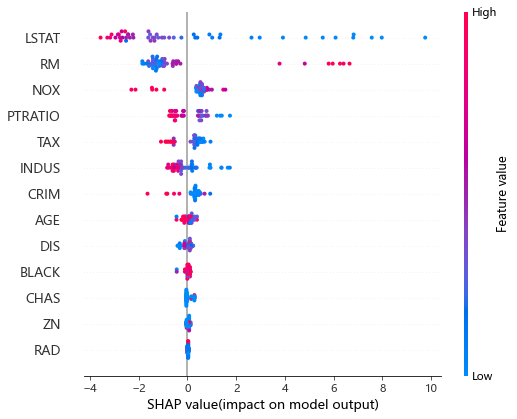

In [13]:
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

shapley_explainer = TreeModelDebriefing.shapley_explainer(result_df, df_test, key='ID', label='MEDV')
shapley_explainer.summary_plot()

### Predictions
Let us look at the predictions.  The predicted values are in 'SCORE' and the actual values are in 'MEDV'.  So, we just rename the 'SCORE' column to 'PREDICTED'

In addition, the column 'CONFIDENCE' is the standard error which is the number of standard deviations away the actual values is from the predicted value.  This column is renamed to 'STANDARD_ERROR'

In [14]:
jdf.head(5).collect()

,PREDICTED_ID,SCORE,UPPER_BOUND,LOWER_BOUND,REASON,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV,ID
0,225,37.5037,5.584693,None,"[{""attr"":""LSTAT"",""pct"":42.0,""val"":6.0833703979...",0.31533,0,6.2,0,0.504,8.266,78.3,2.8944,8,307,17.4,385.05,4.14,44.8,225
1,450,15.4656,2.374665,None,"[{""attr"":""LSTAT"",""pct"":37.0,""val"":-2.850329081...",7.52601,0,18.1,0,0.713,6.417,98.3,2.185,24,666,20.2,304.21,19.31,13,450
2,309,30.2288,8.994242,None,"[{""attr"":""LSTAT"",""pct"":74.0,""val"":6.8095393775...",0.49298,0,9.9,0,0.544,6.635,82.5,3.3175,4,304,18.4,396.9,4.54,22.8,309
3,13,21.5602,2.049750,None,"[{""attr"":""LSTAT"",""pct"":34.0,""val"":-2.213860430...",0.09378,12.5,7.87,0,0.524,5.889,39,5.4509,5,311,15.2,390.5,15.71,21.7,13
4,231,21.8169,2.135401,None,"[{""attr"":""LSTAT"",""pct"":31.0,""val"":-1.604051913...",0.537,0,6.2,0,0.504,5.981,68.1,3.6715,8,307,17.4,378.35,11.65,24.3,231


## Scoring
We now score the results from are test data.  The scoring function we use is R^2.

__In the function below, PAL is not invoked but a query is directly executed against data in HANA__

In [15]:
_, score = model.score(df_test, key='ID', features=features, label=label)
score.collect()

,STAT_NAME,STAT_VALUE
0,EVAR,0.8107667378416284
1,MAE,3.531639215686273
2,MAPE,0.18284853340161858
3,MAX_ERROR,10.805700000000002
4,MSE,19.9306410627451
5,R2,0.8071894731322171
6,RMSE,4.464374655284332
7,WMAPE,0.15175128485971853


## Model
The model is available and can be saved for later predictions.

In [16]:
#  The generated model is in the database.
print(model.model_[0].collect())

     ROW_INDEX  PART_INDEX                                      MODEL_CONTENT
0            0          -1  <PMML version="4.0" xmlns="http://www.dmg.org/...
1            1           0  <PMML version="4.0" xmlns="http://www.dmg.org/...
2            2           1  <PMML version="4.0" xmlns="http://www.dmg.org/...
3            3           2  <PMML version="4.0" xmlns="http://www.dmg.org/...
4            4           3  <PMML version="4.0" xmlns="http://www.dmg.org/...
..         ...         ...                                                ...
96          96          95  <PMML version="4.0" xmlns="http://www.dmg.org/...
97          97          96  <PMML version="4.0" xmlns="http://www.dmg.org/...
98          98          97  <PMML version="4.0" xmlns="http://www.dmg.org/...
99          99          98  <PMML version="4.0" xmlns="http://www.dmg.org/...
100        100          99  <PMML version="4.0" xmlns="http://www.dmg.org/...

[101 rows x 3 columns]


In [17]:
print(model.model_[1].collect())
print(model.model_[2].collect())

    STAT_NAME                                         STAT_VALUE
0         IMP  {"AGE":"0.018307131024253107","BLACK":"0.00731...
1  OUT_OF_BAG  {"0":"4.40011468806744","1":"4.40011468806744"...
Empty DataFrame
Columns: [PARAM_NAME, INT_VALUE, DOUBLE_VALUE, STRING_VALUE]
Index: []


## Close the Connection

In [18]:
connection_context.close()